In [5]:
# Comando Preventivo utile a forzare l'utilizzo di specifici certificati da parte di Speasy presente nell'Ambiente Virtuale
import os, certifi

os.environ["SSL_CERT_FILE"] = certifi.where()
os.environ["REQUESTS_CA_BUNDLE"] = certifi.where()

In [6]:
# Inizializzazione Librerie
import speasy as spz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm
import spiceypy as spice
from datetime import datetime, timezone

In [7]:
# (1) Funzione utile all'esplorazione della libreria di Speasy
def visualizer(folder):
    for voice in dir(folder):
        if not voice.startswith("_"):
            print(voice)
    return voice
# (2) Funzione utile all'esplorazione degli strumenti contenuti sulla sonda Voyager 2
def organizer1():
    catalogue= dir(voy2)
    payload=[]
    for instrument in catalogue:
        if (not instrument.startswith("__")) and any(char.isupper() for char in instrument):
            payload.append(instrument)
        else:
            exit
    return payload
# (3) Funzione utile a semplificare l'accesso ai dati provenienti da speasy:
def veryspeasy(folder,startdata,endata):
    start=str(startdata[2])+"-"+str(startdata[1])+"-"+str(startdata[0])
    end=str(endata[2])+"-"+str(endata[1])+"-"+str(endata[0])
    data_of_folder=spz.get_data(folder,start,end)
    df_list=[]
    for v in data_of_folder.variables:
        v_data=data_of_folder.variables[v]
        df=v_data.to_dataframe()
        df_list.append(df)
    DF=pd.concat(df_list,axis=1)
    return DF

In [8]:
# Rimuovo gli archivi di cui non mi interessano i dati al fine di velocizzare l'estrazione:
spz.config.core.disabled_providers.set('sscweb,cdaweb,csa') 
# Accesso al datatree:
amda_tree = spz.inventories.tree.amda
# Sfrutto la funzione "dir" per comprendere gli elementi presenti all'interno del datatree. Per maggiore comodità filtro gli attributi 
# reali all'interno del dataset tralasciando i "metodi speciali". Questa operazione verrà ripetuta numerose volte, dunque creo una funzione 
# che possa svolgere il lavoro velocemente (1).
print("Voci presenti all'interno del datatree di AMDA:")
visualizer(amda_tree)
print("\n")

Voci presenti all'interno del datatree di AMDA:
Catalogs
Parameters
TimeTables
build_date
clear
spz_name
spz_provider
spz_type
spz_uid




In [9]:
# Tramite autocompletamento navigo nelle sezioni fino a giungere alla missione Voyager 2 di cui ho interesse.
print("Catalogo delle missioni di cui sono presenti informazioni:")
visualizer(amda_tree.Parameters)
print("\n")

Catalogo delle missioni di cui sono presenti informazioni:
ACE
AMPTE
ARTEMIS
Astronomical_Objects_Ephemerides
BepiColombo
Cassini
Cluster
DSCOVR
Double_Star
EISCAT
Freja
Galileo
Geotail
Giotto
HelioSwarm
Helios
ICE
IMP
ISEE
Indices
Interball
JASON3
JUICE
Juno
MAVEN
MESSENGER
MEX
MGS
MMS
Magnetic_Field_Models
Mariner_10
OMNI
PSP
PVO
Phobos_2
Pioneer
Planets_Properties
Polar
Rosetta
SOHO
STEREO
SolarOrbiter
Solar_Irradiance
Solar_Wind_Propagation_Models
Swarm
THEMIS
Ulysses
VEX
Voyager
Wind
clear
desc
is_public
name
spz_name
spz_provider
spz_type
spz_uid
xmlid




In [10]:
# Individuata la "sottocartella" di interesse riguardante la missione Voyager 2 salvo il contenuto in una nuova variabile
voy2=amda_tree.Parameters.Voyager.Voyager_2
# A questo punto, individuato il ramo di interesse, vado ad estrarre una lista contenente la strumentazione di bordo, 
# con apposito filtro (2):
payload=organizer1()
print(payload)

['CRS', 'Ephemeris', 'LECP', 'MAG', 'PLS', 'PWS', 'spaseId']


In [11]:
# Nella variabile payload adesso saranno presenti tutti gli strumenti contenuti sulla sonda Voyager 2, a cui si potrà attingere
# sfruttando la libreria speasy. Per le finalità del progetto si concentri adesso l'attenzione sul PLS e nello specifico 
# sui dati relativi al flyby attorno Urano:
pls=voy2.PLS.flyby_uranus
print("Informazioni contenute nel PLS inerenti il flyby di Urano:")
visualizer(pls)
print("\n")

Informazioni contenute nel PLS inerenti il flyby di Urano:
clear
is_public
name
spz_name
spz_provider
spz_type
spz_uid
vo2_pls_uraelebr
vo2_pls_uraelefit
vo2_pls_uraionbr
vo2_pls_uraionfit
xmlid




In [12]:
# Arrivati a questo punto all'interno della voce PLS sono presenti diversi set dati: 
# - i primi due con la dicitura vo2_pls_uraele si riferiscono a misurazioni riguardanti gli elettroni; 
# - gli ultimi due con la dicitura vo2_pls_uraion si riferiscono a misurazioni riguardanti gli ioni.
# Le voci "br" e "fit", invece, stanno rispettivamente per "browse" e "fit". Dati della tipologia "browse" sono utili per visualizzazioni 
# veloci del dataset, individuazione di animalie, filtraggio intervallo di tempi interessanti; mentre dati della tipologia "fit" sono da 
# preferire per analisi quantitative accurate o per la pubblicazione di risultati affidabili. L'obiettivo di questo lavoro verte sulla 
# rappresentazione di immagini scientifiche attendabili, per cui si farà riferimento solo a quest'ultima tipologia.
e_moments=pls.vo2_pls_uraelefit
i_moments=pls.vo2_pls_uraionfit
# Raggiunte finalmente le variabili di interesse è necessario adesso estrarne i valori per poterli manipolare. Il normale accesso ai dati 
# tramite speasy per quanto comodo nell'ambiente di lavoro è stato per me molto macchinoso e complicato. Motivo per cui ho creato una 
# funzione che rendesse l'estrazione dei dati molto più comoda e veloce (3):
DF_electro=veryspeasy(e_moments,[24,1,1986],[25,1,1986])
DF_ion=veryspeasy(i_moments,[24,1,1986],[25,1,1986])

In [13]:
# Prima di approfondire lo studio e iniziare a manipolare i dati, estraggo le informazioni necessarie relative anche alle effemeridi di 
# Voyager2 in accordo al suo periodo di orbiting intorno a Urano.
eph_H=voy2.Ephemeris.vo2_orb_urahg 
eph_U=voy2.Ephemeris.vo2_orb_urau1
# Le prime sono le efemeridi di Voyager nel SDR eliografico, quindi con origine nel centro del sole, asse Z allineato con asse di 
# rotazione solare (nord solare). È utile a studiare il comportamento di Urano rispetto al vento solare. Mentre le seconde sono le 
# efemeridi di Voyager2 nel SDR centrato su Urano. Questa viene impiegata per comprendere fenomeni locali, come la magnetosfera.
# Individuati i rami di interesse li si manipoli per arrivare ad ottenere anche in questo caso dei dataframe da impiegare.
def GetEff(folder,startdata,endata):
    start=str(startdata[2])+"-"+str(startdata[1])+"-"+str(startdata[0])
    end=str(endata[2])+"-"+str(endata[1])+"-"+str(endata[0])
    df_list=[]
    for v in dir(folder):
        if v.startswith("vo2"):
            v_obj = getattr(folder, v)
            v_data=spz.get_data(v_obj,start,end)
            v_df=v_data.to_dataframe()
            df_list.append(v_df)
    DF_EFFE=pd.concat(df_list,axis=1)
    return DF_EFFE
DF_U=GetEff(eph_U,(24,1,1986),(25,1,1986))
DF_H=GetEff(eph_H,(24,1,1986),(25,1,1986))

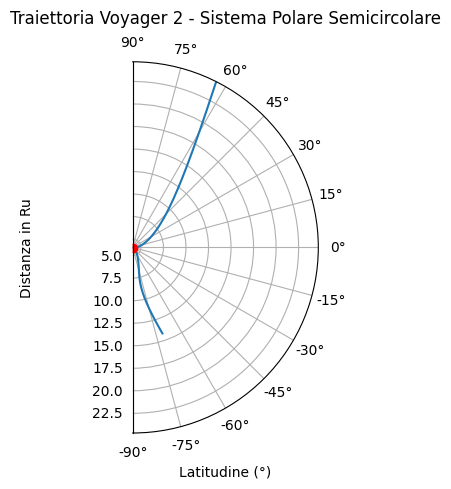

In [14]:
# Di seguito un primo tentativo di rappresentazione di traiettoria in un "Meridian Chart"
# Creazione figura 8x5 pollici con coordinate polari:
fig1 = plt.figure(figsize=(8,5))
ax = plt.subplot(111,polar=True) #Questo 111 serve a chiarire al programma che si vuole una sola area di disegno (1 riga, 1 colonna, 1° plot)
# Limito grafico a un semicerchio:
ax.set_thetamin(0)
ax.set_thetamax(180)
# Personalizzazione dell'aspetto:
ax.set_theta_zero_location('S')  # 0° in basso
ax.set_theta_direction(1)       # Angoli crescono in senso antiorario

# Imposta raggio massimo arbitrario:
ax.set_rlim(min(DF_U['distance vo2-uran'])-0.1, max(DF_U['distance vo2-uran'])+0.1)

#Plot Effettivo dei Dati
lat_plot=np.radians((DF_U['lat_ul'])+90)
ax.plot(lat_plot,DF_U['distance vo2-uran'])
ax.plot((min(lat_plot)),min(DF_U['distance vo2-uran']),'ro')
# Etichette degli assi
ax.set_thetagrids([0, 15, 30, 45, 60, 75, 90, 105, 120, 135, 150, 165, 180],
                  labels=['-90°', '-75°', '-60°','-45°', '-30°','-15°','0°', '15°', '30°', '45°','60°','75°','90°']) #Sistema gli intervalli per far comparire -90,90
ax.set_title('Traiettoria Voyager 2 - Sistema Polare Semicircolare', va='bottom') #allinea il titolo leggermente in basso (utile per non sovrapporlo all’origine del grafico)
ax.set_xlabel('Latitudine (°)')
ax.set_ylabel('Distanza in Ru')

# Mostra il grafico
plt.tight_layout()
plt.show()

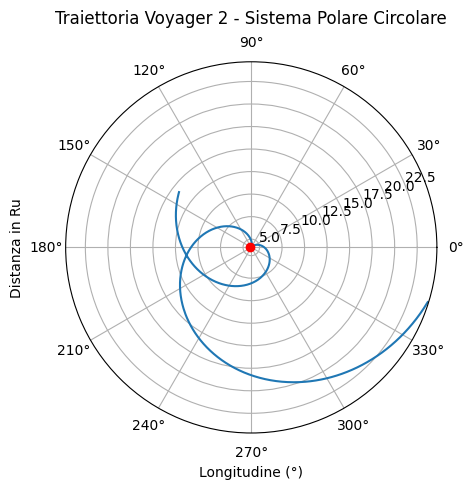

In [15]:
# Di seguito il proseguimento del tentativo di rappresentazione di traiettoria in un "Phase Chart"
# Creazione figura 8x5 pollici con coordinate polari:
fig2 = plt.figure(figsize=(8,5))
ax = plt.subplot(111,polar=True) #Questo 111 serve a chiarire al programma che si vuole una sola area di disegno (1 riga, 1 colonna, 1° plot)
# Limito grafico a un semicerchio:
ax.set_thetamin(0)
ax.set_thetamax(360)
# Personalizzazione dell'aspetto:
ax.set_theta_zero_location('E')  # 0° in basso
ax.set_theta_direction(1)       # Angoli crescono in senso antiorario

# Imposta raggio massimo arbitrario:
ax.set_rlim(min(DF_U['distance vo2-uran'])-0.1, max(DF_U['distance vo2-uran'])+0.1)

#Plot Effettivo dei Dati
lon_plot=np.radians((DF_U['lon_ul']))
ax.plot(lon_plot,DF_U['distance vo2-uran'])
ax.plot((min(lon_plot)),min(DF_U['distance vo2-uran']),'ro')
# Etichette degli assi
ax.set_thetagrids([0,30,60,90,120,150,180,210,240,270,300,330]) #Sistema gli intervalli per far comparire -90,90
ax.set_title('Traiettoria Voyager 2 - Sistema Polare Circolare', va='bottom') #allinea il titolo leggermente in basso (utile per non sovrapporlo all’origine del grafico)
ax.set_xlabel('Longitudine (°)')
ax.set_ylabel('Distanza in Ru',labelpad=30)

# Mostra il grafico
plt.tight_layout()
plt.show()

In [16]:
# I dati restituiti dalla libreria SpiceyPy e Speasy non coincidono totalmente il che fa comprendere che nella stima del primo caso e nella 
# rilevazione del secondo caso sono state impiegate due terne di riferimento differenti. Adottando un SDR NON INERZIALE e planetocentrico 
# nei confronti di Urano per la stima di SpiceyPy ho però notato che i valori dell'asse Z sono apprezzabilmente simili motivo per cui posso 
# dedurre che il sistema adottato da AMDA, di cui non ho alcun dettaglio, sia analogo a IAU_URANUS, ma con asse X e Y ruotati nel piano di 
# un certo angolo theta. Nelle righe successive cercherò di calcolare questo theta e costruirmi di conseguenza la matrice di rotazione che 
# trasformi i dati provenienti da SpiceyPy in misure apprezzabili con quelle ricavate dalla sonda e presenti nel database di AMDA

# Carico il metakernel (NECESSARIO OGNI VOLTA CHE SI UTILIZZA LA LIBRERIA)
spice.furnsh("vo2MetaK.txt")
timespan=list(DF_U.index)
thetalist=[]
for t in timespan:
    tc=t.to_pydatetime() #converto timestamp di pandas in datatime di python
    et=spice.datetime2et(tc)
    pos, _ = spice.spkpos("VOYAGER 2", et, "IAU_URANUS", "NONE", "URANUS BARYCENTER")
    pos_ru=pos/25559.0
    vec_xy_spice=pos_ru[:2] #stima della posizione elaborata da SpiceyPy
    DF_U_t=DF_U.loc[DF_U.index==t]
    x_val_amda=DF_U_t["x"].iloc[0]
    y_val_amda=DF_U_t["y"].iloc[0]
    theta=np.arctan2(y_val_amda,x_val_amda)-np.arctan2(vec_xy_spice[1],vec_xy_spice[0])
    thetalist.append(theta)
    # Creazione della Matrice di rotazione
    M_rot = np.array([[np.cos(theta), -np.sin(theta), 0],
                    [np.sin(theta),  np.cos(theta), 0],
                    [0,              0,             -1]])
    # Applica la rotazione
    pos_spice_rotated = M_rot @ pos_ru
    #print(pos_spice_rotated)
# Pulizia sempre dopo Operazioni
spice.kclear()

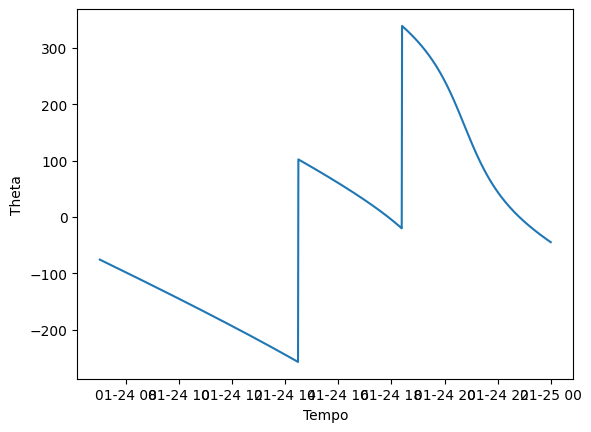

In [17]:
thetalist_deg=[(180/np.pi)*d for d in thetalist]
plt.plot(timespan,thetalist_deg)
plt.ylabel("Theta")
plt.xlabel("Tempo")
plt.show()

In [18]:
# Una volta riuscito nell'intento posso utilizzare le capacità generative di posizione di spiceypy per calcolare la posizione della sonda 
# Voyager nei clock di tempo di operazione del PLS. Per riuscire in questo la mia idea consiste nello scrivere un codice che generi la 
# posizione e successivamente la corregga nella terna adottata nelle misurazioni AMDA adattando il theta corrispondente alla misura di tempo
# più vicina rilevata. In questo modo potrò creare un Dataframe definitivo generale al cui interno saranno presenti i valori di posizione 
# corrispondenti agli istanti di tempo operativi: 
editor=pd.DataFrame({"delta t": timespan,"theta": thetalist}) #tabella che associa ad ogni istante di tempo delle effemeridi il corrispettivo angolo theta di correzione
editor["delta t"] = pd.to_datetime(editor["delta t"])
editor = editor.set_index("delta t")
# Creo la funzione in grado di trovarmi l'istante di tempo più vicino nel set delle effemeridi relativo a quello del PLS
def timematch(lista_principale, lista_riferimento):
    main_arr = np.array(lista_principale, dtype='datetime64[us]').astype('int64')
    ref_arr = np.array(lista_riferimento, dtype='datetime64[us]').astype('int64')
    # Crea matrice con elementi corrispondenti alle differenze fra valori principali e di riferimento
    diff = np.abs(main_arr[:, np.newaxis] - ref_arr)
    # Qui si trova per ogni riga (ogni tempo principale) l'indice della colonna (tempo di riferimento) con la differenza minima.
    indici_vicini = np.argmin(diff, axis=1)
    return lista_riferimento[indici_vicini]
# Sfrutto la funzione con le liste di interesse convertendole appositamente in un formato congruo
timespan=DF_U.index.to_numpy(dtype='datetime64[ns]')
timespan_PLS=DF_ion.index.to_numpy(dtype='datetime64[ns]')
risultati=timematch(timespan_PLS,timespan)
# Da qui provo a generare le coordinate del segmento di interesse applicando le correzioni dette all'inizio:
PLS_generated_positioning=[]
spice.furnsh("vo2MetaK.txt")
for originale, vicino in zip(timespan_PLS, risultati):
    #print(f"Originale: {originale} -> Più vicino: {vicino}")
    originale_corr=originale.astype(str)
    et=spice.str2et(originale_corr)
    pos_PLS, _ = spice.spkpos("VOYAGER 2", et, "IAU_URANUS", "NONE", "URANUS BARYCENTER")
    pos_PLS_ru=pos_PLS/25559.0
    # Creazione della Matrice di rotazione con il theta idoneo al valore più vicino
    theta_id = editor.loc[pd.Timestamp(vicino), "theta"]
    M_rot = np.array([[np.cos(theta_id), -np.sin(theta_id), 0],
                    [np.sin(theta_id),  np.cos(theta_id), 0],
                    [0,              0,             -1]])
    # Applica la rotazione
    pos_spice_PLS_rotated = M_rot @ pos_PLS_ru
    PLS_generated_positioning.append(pos_spice_PLS_rotated)
spice.kclear()

In [19]:
# Generata e corretta la posizione della sonda Voyager 2 durante l'intervallo di funzionamento dello strumento PLS, vado a 
# introdurre tale informazione nel DataFrame originale per convenienza di utilizzi successivi
def divider_ion(lista_coordinate):
    import pandas as pd
    import numpy as np
    x_lista_coordinate=[]
    y_lista_coordinate=[]
    z_lista_coordinate=[]
    for coord in lista_coordinate:
        x_lista_coordinate.append(coord[0])
        y_lista_coordinate.append(coord[1])
        z_lista_coordinate.append(coord[2])
    data={"delta t":timespan_PLS,"x":x_lista_coordinate,"y":y_lista_coordinate,"z":z_lista_coordinate}
    df=pd.DataFrame(data)
    return df
DF_ion_pos=divider_ion(PLS_generated_positioning)
DF_ion_pos["delta t"] = pd.to_datetime(DF_ion_pos["delta t"])
DF_ion_pos = DF_ion_pos.set_index("delta t")
# Creato il DataFrame con le posizioni Generate lo unisco finalmente a quello estratto inizialmente da AMDA:
DF_ion_pos = DF_ion_pos.rename(columns={
    "x": "pos_x",
    "y": "pos_y",
    "z": "pos_z"
})
DF_ion = DF_ion.join(DF_ion_pos)

In [20]:
# A questo punto ripeto la stessa procedura per andare a completare il DataFrame DF_electro delle corrispondenti informazioni di posizione:
timespan_PLS_ele=DF_electro.index.to_numpy(dtype='datetime64[ns]')
risultati=timematch(timespan_PLS_ele,timespan)
# Da qui provo a generare le coordinate del segmento di interesse applicando le correzioni dette all'inizio:
PLS_generated_positioning_ele=[]
spice.furnsh("vo2MetaK.txt")
for originale, vicino in zip(timespan_PLS_ele, risultati):
    originale_corr=originale.astype(str)
    et=spice.str2et(originale_corr)
    pos_PLS_ele, _ = spice.spkpos("VOYAGER 2", et, "IAU_URANUS", "NONE", "URANUS BARYCENTER")
    pos_PLS_ele_ru=pos_PLS_ele/25559.0
    # Creazione della Matrice di rotazione con il theta idoneo al valore più vicino
    theta_id = editor.loc[pd.Timestamp(vicino), "theta"]
    M_rot = np.array([[np.cos(theta_id), -np.sin(theta_id), 0],
                    [np.sin(theta_id),  np.cos(theta_id), 0],
                    [0,              0,             -1]])
    # Applica la rotazione
    pos_spice_PLS_rotated_ele = M_rot @ pos_PLS_ele_ru
    PLS_generated_positioning_ele.append(pos_spice_PLS_rotated_ele)
def divider_electro(lista_coordinate):
    import pandas as pd
    import numpy as np
    x_lista_coordinate=[]
    y_lista_coordinate=[]
    z_lista_coordinate=[]
    for coord in lista_coordinate:
        x_lista_coordinate.append(coord[0])
        y_lista_coordinate.append(coord[1])
        z_lista_coordinate.append(coord[2])
    data={"delta t":timespan_PLS_ele,"x":x_lista_coordinate,"y":y_lista_coordinate,"z":z_lista_coordinate}
    df=pd.DataFrame(data)
    return df
DF_electro_pos=divider_electro(PLS_generated_positioning_ele)
DF_electro_pos["delta t"] = pd.to_datetime(DF_electro_pos["delta t"])
DF_electro_pos = DF_electro_pos.set_index("delta t")
# Creato il DataFrame con le posizioni Generate lo unisco finalmente a quello estratto inizialmente da AMDA:
DF_electro_pos = DF_electro_pos.rename(columns={
    "x": "pos_x",
    "y": "pos_y",
    "z": "pos_z"
})
DF_electro = DF_electro.join(DF_electro_pos)

In [21]:
# Arrivati a questo punto il passo finale per la manipolazione dei dati consiste nel convertire le misure stimate in termini di distanza, 
# longitudine e latitudine. Il metodo per farlo, però, non è affatto scontato. Di seguito riporto la funzione che ho scritto per attuare 
# tale conversione basandomi completamente su un'ipotesi: il dataframe di AMDA utilizza due sistemi di riferimento (cartesiani e sferici) 
# di cui non è possibile ricavare informazioni se non in maniera empirica ed entrambi diversi da quelli standard ben caratterizzati (es. IAU)
# Sulla base di queste considerazioni dunque quello che si fa con la seguente funzione di conversione è:
# - Prendere le coordinate xyz del sistema calcolate in modo analogo a quelle del sistema cartesiano AMDA;
# - Ruotarle di un nuovo angolo theta che allinea il sistema cartesiano xyz di AMDA con un secondo sistema cartesiano x'y'z' a partire dal quale
#   vengono definite le coordinate sferiche;
# - Trasformare effettivamente le coordinate del secondo sistema x'y'z' in coordinate sferiche in termini di distanza,longitudine e latitudine

# Utility per convertire xyz -> (r, lon, lat) coerenti con AMDA
# applicando una rotazione intorno a z di ampiezza theta(t) = a + b * (giorni da t0).
# I parametri a,b,t0 sono stimati dal dataset DF_U andando a calcolare la differenza fra la longitudine standard calcolata con la funzione
# atan2(y,x) e lon_ul e "srotolando" tale grandezza in dipendenza della variabile tempo

# Parametri del fit (da dataset)
T0_UTC_ISO = "1986-01-24 07:00:48.005000Z"  # t0 in UTC ISO
A_DEG = 149.5103807925583          # offset a [deg] alla data T0_UTC_ISO
B_DEG_PER_DAY = -555.285415241088  # slope b [deg/day]

def rll_from_xyz_amda_aligned(x, y, z, t_utc):
    """
    Converte da coordinate cartesiane (x,y,z) a (r,lon,lat) in modo coerente con AMDA,
    applicando prima la rotazione attorno a z di theta(t) = A + B * giorni_dal_t0.

    Parametri
    ---------
    x, y, z : float o array-like 
    t_utc : pandas.Timestamp / numpy.datetime64 / datetime.datetime (timezone-aware in UTC) o array-like
        Tempo (o array di tempi) corrispondente alle coordinate.

    Ritorna
    -------
    r : array
        Distanza euclidea
    lon_deg : array
        Longitudine in gradi 
    lat_deg : array
        Latitudine planetocentrica in gradi [-90, 90]
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    z = np.asarray(z, dtype=float)

    # Assicura numpy datetime64[ns]
    t = pd.to_datetime(t_utc, utc=True).to_numpy(dtype="datetime64[ns]")
    t0 = np.datetime64(T0_UTC_ISO)

    # giorni dall'epoca t0
    dt_days = (t - t0).astype("timedelta64[ns]").astype(float) / (86400e9)

    # rotazione intorno a z: +theta per passare da IAU-like -> AMDA
    theta_deg = A_DEG + B_DEG_PER_DAY * dt_days
    th = np.deg2rad(theta_deg)
    c, s = np.cos(th), np.sin(th)

    # Applica rotazione per ogni elemento (broadcast sicuro)
    xp = c * x - s * y
    yp = s * x + c * y
    zp = z

    # Sferiche (planetocentriche)
    r = np.sqrt(xp*xp + yp*yp + zp*zp)
    lat = np.degrees(np.arctan2(zp, np.sqrt(xp*xp + yp*yp)))
    lon = (np.degrees(np.arctan2(yp, xp)))

    return r, lon, lat

In [22]:
# Definita la funzione la applico ai diversi DataFrame. Inizio da DF_ion
r,lon,lat=rll_from_xyz_amda_aligned(DF_ion["pos_x"], DF_ion["pos_y"], DF_ion["pos_z"], DF_ion.index)
# Assegna i risultati al DataFrame
DF_ion["r"] = r
DF_ion["lon_deg"] = lon
DF_ion["lat_deg"] = lat
# Ripulisco i dati per facilitare i prossimi calcoli
del r,lon,lat

# Successivamente Applico a DF_electro
r,lon,lat=rll_from_xyz_amda_aligned(DF_electro["pos_x"], DF_electro["pos_y"], DF_electro["pos_z"], DF_electro.index)
DF_electro["r"] = r
DF_electro["lon_deg"] = lon
DF_electro["lat_deg"] = lat
# Ripulisco i dati per pulizia
del r,lon,lat

C:\Users\thoma\AppData\Local\Temp\ipykernel_516\3494077580.py:47: UserWarning: no explicit representation of timezones available for np.datetime64
  t0 = np.datetime64(T0_UTC_ISO)
C:\Users\thoma\AppData\Local\Temp\ipykernel_516\3494077580.py:47: UserWarning: no explicit representation of timezones available for np.datetime64
  t0 = np.datetime64(T0_UTC_ISO)


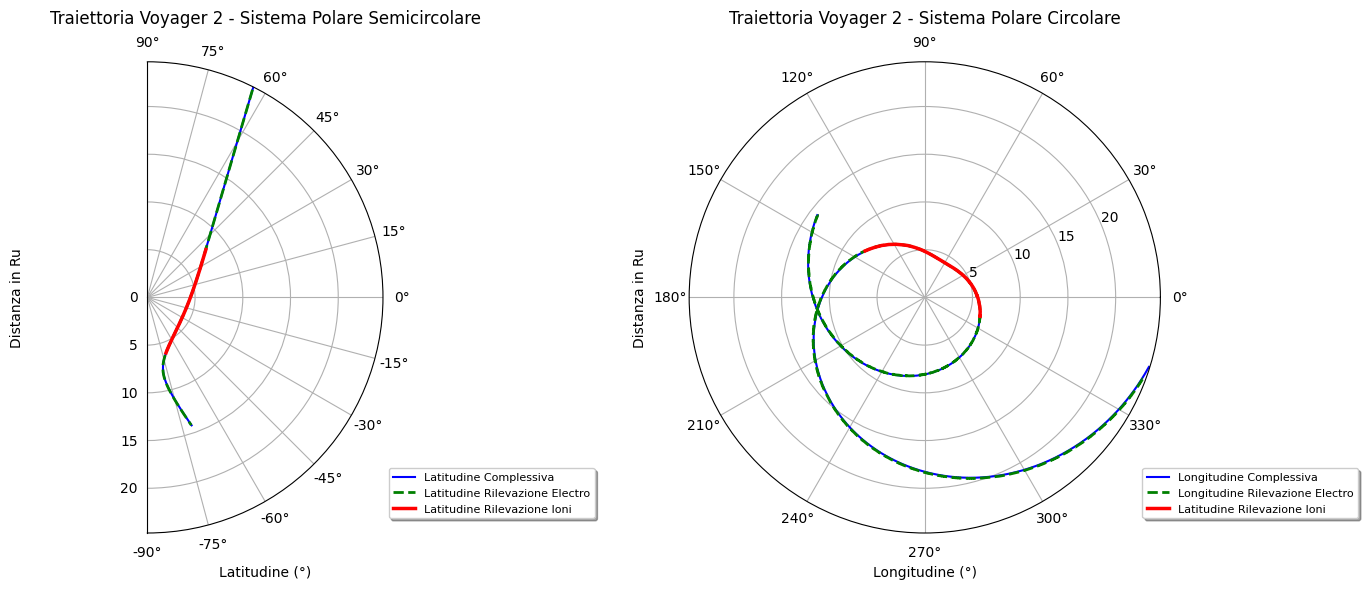

In [23]:
# Conclusa la parte di elaborazione dati utile alla sintesi delle coordinate sferiche della sonda nei timespan di funzionamento del PLS, da
# questo punto in poi si creano tutte le immagini utili ad ottenere una migliore interpretazione dei dati raccolti:

# GRAFICO 1: Rappresentazione delle Traiettoria del Satellite e delle Porzioni di Funzionamento del PLS
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'polar': True}, figsize=(14,6))

# Grafico 1a: Meridian Chart
ax1.set_thetamin(0)
ax1.set_thetamax(180)
ax1.set_theta_zero_location('S')
ax1.set_theta_direction(1)

ax1.set_rlim(0,
             max(DF_U['distance vo2-uran'])+0.1)

lat_plot = np.radians((DF_U['lat_ul'])+90)
ax1.plot(lat_plot, DF_U['distance vo2-uran'], color="blue", linewidth=1.5, label="Latitudine Complessiva")

latPLS_electro_plot = np.radians((DF_electro['lat_deg'])+90)
ax1.plot(latPLS_electro_plot, DF_electro['r'], color="green", linewidth=2, linestyle='--', label="Latitudine Rilevazione Electro")

latPLS_ion_plot = np.radians((DF_ion['lat_deg'])+90)
ax1.plot(latPLS_ion_plot, DF_ion['r'], color="red", linewidth=2.5, label="Latitudine Rilevazione Ioni")

ax1.set_thetagrids([0,15,30,45,60,75,90,105,120,135,150,165,180],
                   labels=['-90°','-75°','-60°','-45°','-30°','-15°','0°','15°','30°','45°','60°','75°','90°'])
ax1.set_title('Traiettoria Voyager 2 - Sistema Polare Semicircolare', va='bottom')
ax1.set_xlabel('Latitudine (°)')
ax1.set_ylabel('Distanza in Ru')
ax1.legend(loc='lower left', bbox_to_anchor=(0.75, 0.02),
           frameon=True, shadow=True, fancybox=True, fontsize=8)

# Grafico 1b: Phase Chart
ax2.set_thetamin(0)
ax2.set_thetamax(360)
ax2.set_theta_zero_location('E')
ax2.set_theta_direction(1)

ax2.set_rlim(0,
             max(DF_U['distance vo2-uran'])+0.1)

lon_plot = np.radians(DF_U['lon_ul'])
ax2.plot(lon_plot, DF_U['distance vo2-uran'], color="blue", linewidth=1.5, label="Longitudine Complessiva")

lonPLS_electro_plot = np.radians((DF_electro['lon_deg']))
ax2.plot(lonPLS_electro_plot, DF_electro['r'], color="green", linewidth=2, linestyle='--', label="Longitudine Rilevazione Electro")

lonPLS_ion_plot = np.radians((DF_ion['lon_deg']))
ax2.plot(lonPLS_ion_plot, DF_ion['r'], color="red", linewidth=2.5, label="Latitudine Rilevazione Ioni")

ax2.set_thetagrids([0,30,60,90,120,150,180,210,240,270,300,330])
ax2.set_title('Traiettoria Voyager 2 - Sistema Polare Circolare', va='bottom')
ax2.set_xlabel('Longitudine (°)')
ax2.set_ylabel('Distanza in Ru', labelpad=30)
ax2.legend(loc='lower left', bbox_to_anchor=(0.95, 0.02),
           frameon=True, shadow=True, fancybox=True, fontsize=8)

# Mostro il risultato combinato
plt.tight_layout()
plt.show()


C:\Users\thoma\AppData\Local\Temp\ipykernel_516\2036289408.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(loc='lower left', bbox_to_anchor=(0.75, 0.02),
C:\Users\thoma\AppData\Local\Temp\ipykernel_516\2036289408.py:56: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(loc='lower left', bbox_to_anchor=(0.95, 0.02),


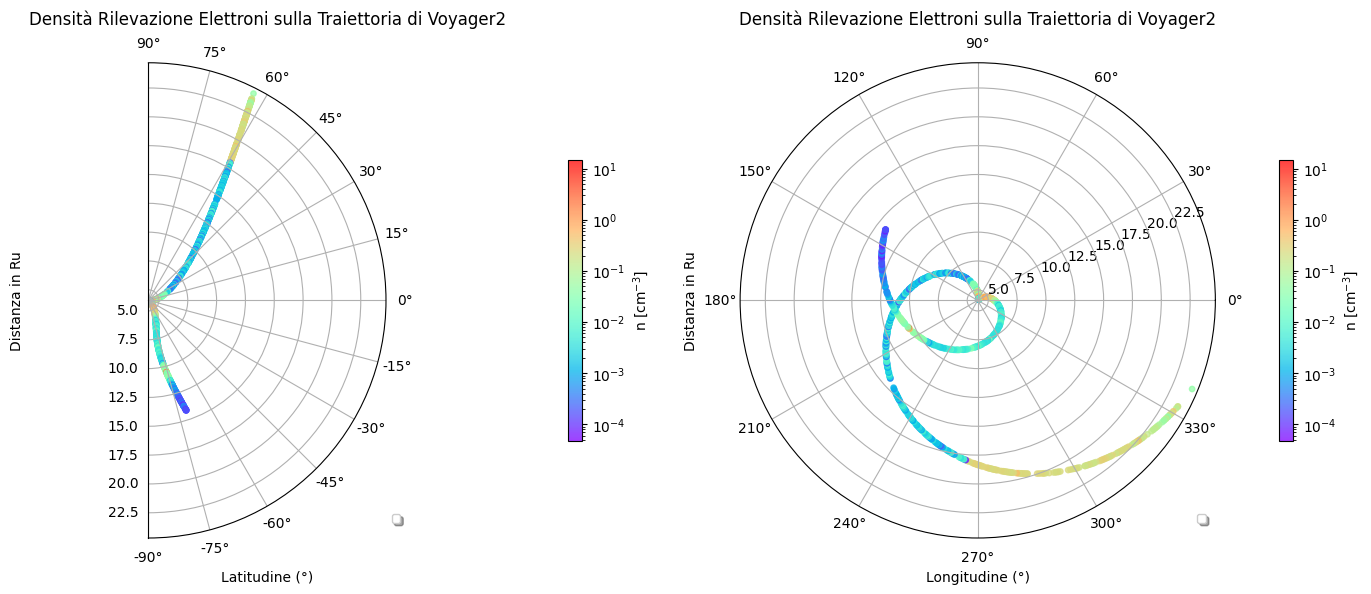

In [24]:
# GRAFICO 2: Rappresentazione delle Densità Totali di Elettroni Rilevate:
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'polar': True}, figsize=(14,6))

# Grafico 1a: Meridian Chart
ax1.set_thetamin(0)
ax1.set_thetamax(180)
ax1.set_theta_zero_location('S')
ax1.set_theta_direction(1)

ax1.set_rlim(min(DF_U['distance vo2-uran'])-0.1,
             max(DF_U['distance vo2-uran'])+0.1)

latPLS_electro_plot = np.radians((DF_electro['lat_deg'])+90)
#ax1.plot(latPLS_electro_plot, DF_electro['r'], color="magenta", linewidth=1.5, linestyle='--', label="Latitudine Rilevazione Electro")
sc1=ax1.scatter(latPLS_electro_plot,DF_electro['r'],c=DF_electro['density total'],cmap='rainbow', norm=LogNorm(),s=15,alpha=0.75)

# Aggiungo la Colorbar
cbar = plt.colorbar(sc1, ax=ax1, pad=0.1,shrink=0.5)
cbar.set_label("n [cm$^{-3}$]")  # etichetta della variabile
# Adotto una formattazione logaritmica
cbar.formatter = ticker.LogFormatterMathtext(base=10)
cbar.update_ticks()

ax1.set_thetagrids([0,15,30,45,60,75,90,105,120,135,150,165,180],
                   labels=['-90°','-75°','-60°','-45°','-30°','-15°','0°','15°','30°','45°','60°','75°','90°'])
ax1.set_title('Densità Rilevazione Elettroni sulla Traiettoria di Voyager2', va='bottom')
ax1.set_xlabel('Latitudine (°)')
ax1.set_ylabel('Distanza in Ru')
ax1.legend(loc='lower left', bbox_to_anchor=(0.75, 0.02),
           frameon=True, shadow=True, fancybox=True, fontsize=8)

# Grafico 1b: Phase Chart
ax2.set_thetamin(0)
ax2.set_thetamax(360)
ax2.set_theta_zero_location('E')
ax2.set_theta_direction(1)

ax2.set_rlim(min(DF_U['distance vo2-uran'])-0.1,
             max(DF_U['distance vo2-uran'])+0.1)

lonPLS_electro_plot = np.radians((DF_electro['lon_deg']))
#ax2.plot(lonPLS_electro_plot, DF_electro['r'], color="magenta", linewidth=1.5, linestyle='--', label="Longitudine Rilevazione Electro")
sc2=ax2.scatter(lonPLS_electro_plot, DF_electro['r'], c=DF_electro['density total'],cmap='rainbow',norm=LogNorm(),s=15,alpha=0.75)

# Qui si aggiunge la Colorbar
cbar = plt.colorbar(sc2, ax=ax2, pad=0.1,shrink=0.5)
cbar.set_label("n [cm$^{-3}$]")  # etichetta della variabile
# Adotto una formattazione logaritmica
cbar.formatter = ticker.LogFormatterMathtext(base=10)
cbar.update_ticks()

ax2.set_thetagrids([0,30,60,90,120,150,180,210,240,270,300,330])
ax2.set_title('Densità Rilevazione Elettroni sulla Traiettoria di Voyager2', va='bottom')
ax2.set_xlabel('Longitudine (°)')
ax2.set_ylabel('Distanza in Ru', labelpad=30)
ax2.legend(loc='lower left', bbox_to_anchor=(0.95, 0.02),
           frameon=True, shadow=True, fancybox=True, fontsize=8)

# Mostro il risultato combinato
plt.tight_layout()
plt.show()

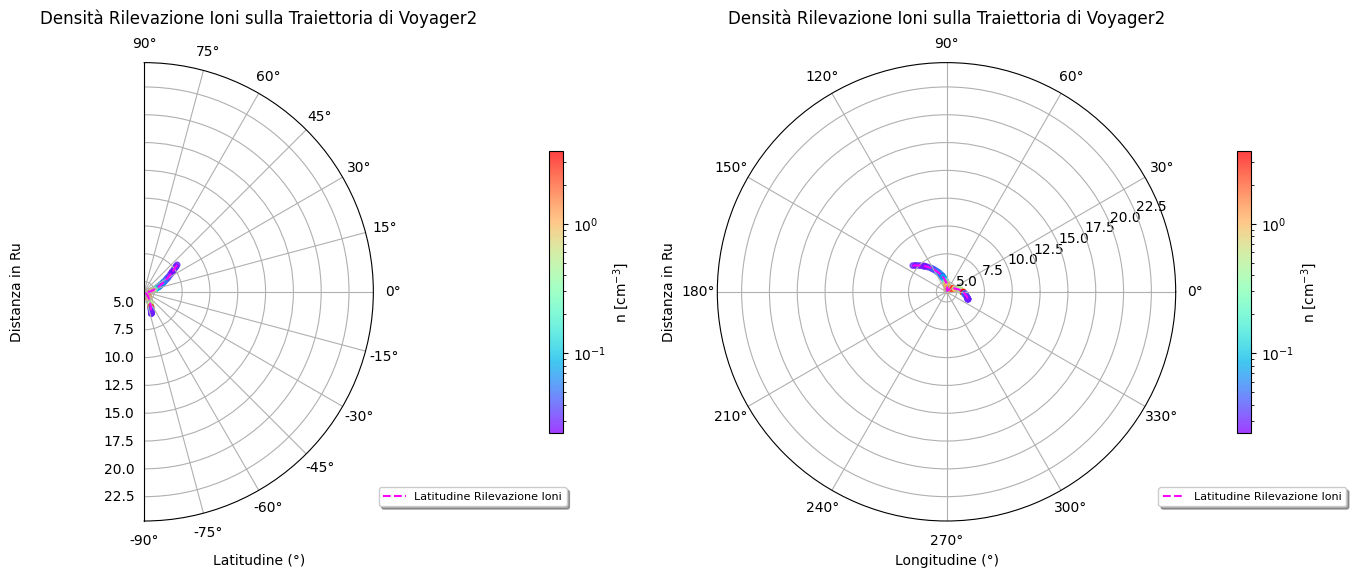

In [25]:
# GRAFICO 3: Rappresentazione delle Densità Totali di Ioni Rilevate:
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'polar': True}, figsize=(14,6))

# Grafico 1a: Meridian Chart
ax1.set_thetamin(0)
ax1.set_thetamax(180)
ax1.set_theta_zero_location('S')
ax1.set_theta_direction(1)

ax1.set_rlim(min(DF_U['distance vo2-uran'])-0.1,
             max(DF_U['distance vo2-uran'])+0.1)

latPLS_ion_plot = np.radians((DF_ion['lat_deg'])+90)
density_total_ion= DF_ion["density comp1"]+ DF_ion["density comp2"]+ DF_ion["density comp3"] # Calcolo la densità totale degli ioni sommando le densità delle singole componenti
ax1.plot(latPLS_ion_plot, DF_ion['r'], color="magenta", linestyle='--', linewidth=1.5, label="Latitudine Rilevazione Ioni")
sc1=ax1.scatter(latPLS_ion_plot, DF_ion['r'], c=density_total_ion,cmap='rainbow',norm=LogNorm(),s=15,alpha=0.75)

# Qui si aggiunge la Colorbar
cbar = plt.colorbar(sc1, ax=ax1, pad=0.1,shrink=0.5)
cbar.set_label("n [cm$^{-3}$]")  # etichetta della variabile
# Adotto una formattazione logaritmica
cbar.formatter = ticker.LogFormatterMathtext(base=10)
cbar.update_ticks()

ax1.set_thetagrids([0,15,30,45,60,75,90,105,120,135,150,165,180],
                   labels=['-90°','-75°','-60°','-45°','-30°','-15°','0°','15°','30°','45°','60°','75°','90°'])
ax1.set_title('Densità Rilevazione Ioni sulla Traiettoria di Voyager2', va='bottom')
ax1.set_xlabel('Latitudine (°)')
ax1.set_ylabel('Distanza in Ru')
ax1.legend(loc='lower left', bbox_to_anchor=(0.75, 0.02),
           frameon=True, shadow=True, fancybox=True, fontsize=8)

# Grafico 1b: Phase Chart
ax2.set_thetamin(0)
ax2.set_thetamax(360)
ax2.set_theta_zero_location('E')
ax2.set_theta_direction(1)

ax2.set_rlim(min(DF_U['distance vo2-uran'])-0.1,
             max(DF_U['distance vo2-uran'])+0.1)

lonPLS_ion_plot = np.radians((DF_ion['lon_deg']))
ax2.plot(lonPLS_ion_plot, DF_ion['r'], color="magenta", linestyle='--', linewidth=1.5, label="Latitudine Rilevazione Ioni")
sc2=ax2.scatter(lonPLS_ion_plot, DF_ion['r'], c=density_total_ion,cmap='rainbow',norm=LogNorm(),s=15,alpha=0.75)

# Qui si aggiunge la Colorbar
cbar = plt.colorbar(sc2, ax=ax2, pad=0.1,shrink=0.5)
cbar.set_label("n [cm$^{-3}$]")  # etichetta della variabile
# Adotto una formattazione logaritmica
cbar.formatter = ticker.LogFormatterMathtext(base=10)
cbar.update_ticks()

ax2.set_thetagrids([0,30,60,90,120,150,180,210,240,270,300,330])
ax2.set_title('Densità Rilevazione Ioni sulla Traiettoria di Voyager2', va='bottom')
ax2.set_xlabel('Longitudine (°)')
ax2.set_ylabel('Distanza in Ru', labelpad=30)
ax2.legend(loc='lower left', bbox_to_anchor=(0.95, 0.02),
           frameon=True, shadow=True, fancybox=True, fontsize=8)

# Mostro il risultato combinato
plt.tight_layout()
plt.show()

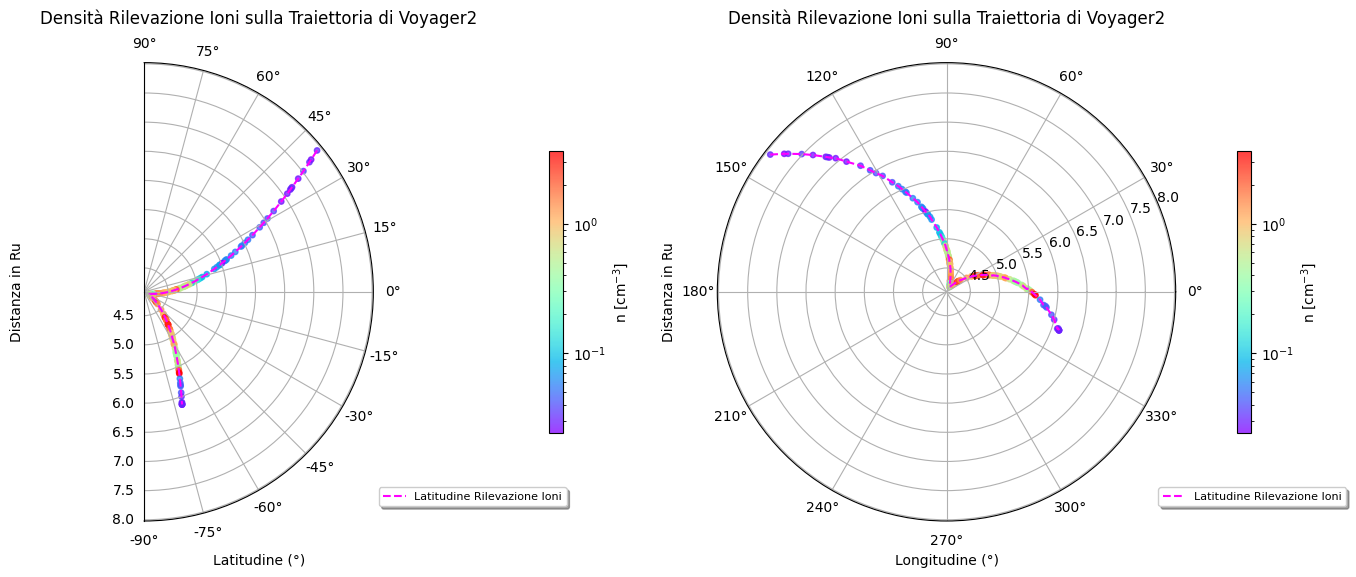

In [26]:
# Grafico 3a: Offro un ingrandimento visivo della precedente immagine generata
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'polar': True}, figsize=(14,6))

# Grafico 1a: Meridian Chart
ax1.set_thetamin(0)
ax1.set_thetamax(180)
ax1.set_theta_zero_location('S')
ax1.set_theta_direction(1)

ax1.set_rlim(min(DF_ion['r'])-0.1,
             max(DF_ion['r'])+0.1)

latPLS_ion_plot = np.radians((DF_ion['lat_deg'])+90)
density_total_ion= DF_ion["density comp1"]+ DF_ion["density comp2"]+ DF_ion["density comp3"] # Calcolo la densità totale degli ioni sommando le densità delle singole componenti
ax1.plot(latPLS_ion_plot, DF_ion['r'], color="magenta", linestyle='--', linewidth=1.5, label="Latitudine Rilevazione Ioni")
sc1=ax1.scatter(latPLS_ion_plot, DF_ion['r'], c=density_total_ion,cmap='rainbow',norm=LogNorm(),s=15,alpha=0.75)

# Qui si aggiunge la Colorbar
cbar = plt.colorbar(sc1, ax=ax1, pad=0.1,shrink=0.5)
cbar.set_label("n [cm$^{-3}$]")  # etichetta della variabile
# Adotto una formattazione logaritmica
cbar.formatter = ticker.LogFormatterMathtext(base=10)
cbar.update_ticks()

ax1.set_thetagrids([0,15,30,45,60,75,90,105,120,135,150,165,180],
                   labels=['-90°','-75°','-60°','-45°','-30°','-15°','0°','15°','30°','45°','60°','75°','90°'])
ax1.set_title('Densità Rilevazione Ioni sulla Traiettoria di Voyager2', va='bottom')
ax1.set_xlabel('Latitudine (°)')
ax1.set_ylabel('Distanza in Ru')
ax1.legend(loc='lower left', bbox_to_anchor=(0.75, 0.02),
           frameon=True, shadow=True, fancybox=True, fontsize=8)

# Grafico 1b: Phase Chart
ax2.set_thetamin(0)
ax2.set_thetamax(360)
ax2.set_theta_zero_location('E')
ax2.set_theta_direction(1)

ax2.set_rlim(min(DF_ion['r'])-0.1,
             max(DF_ion['r'])+0.1)

lonPLS_ion_plot = np.radians((DF_ion['lon_deg']))
ax2.plot(lonPLS_ion_plot, DF_ion['r'], color="magenta", linestyle='--', linewidth=1.5, label="Latitudine Rilevazione Ioni")
sc2=ax2.scatter(lonPLS_ion_plot, DF_ion['r'], c=density_total_ion,cmap='rainbow',norm=LogNorm(),s=15,alpha=0.75)

# Qui si aggiunge la Colorbar
cbar = plt.colorbar(sc2, ax=ax2, pad=0.1,shrink=0.5)
cbar.set_label("n [cm$^{-3}$]")  # etichetta della variabile
# Adotto una formattazione logaritmica
cbar.formatter = ticker.LogFormatterMathtext(base=10)
cbar.update_ticks()

ax2.set_thetagrids([0,30,60,90,120,150,180,210,240,270,300,330])
ax2.set_title('Densità Rilevazione Ioni sulla Traiettoria di Voyager2', va='bottom')
ax2.set_xlabel('Longitudine (°)')
ax2.set_ylabel('Distanza in Ru', labelpad=30)
ax2.legend(loc='lower left', bbox_to_anchor=(0.95, 0.02),
           frameon=True, shadow=True, fancybox=True, fontsize=8)

# Mostro il risultato combinato
plt.tight_layout()
plt.show()

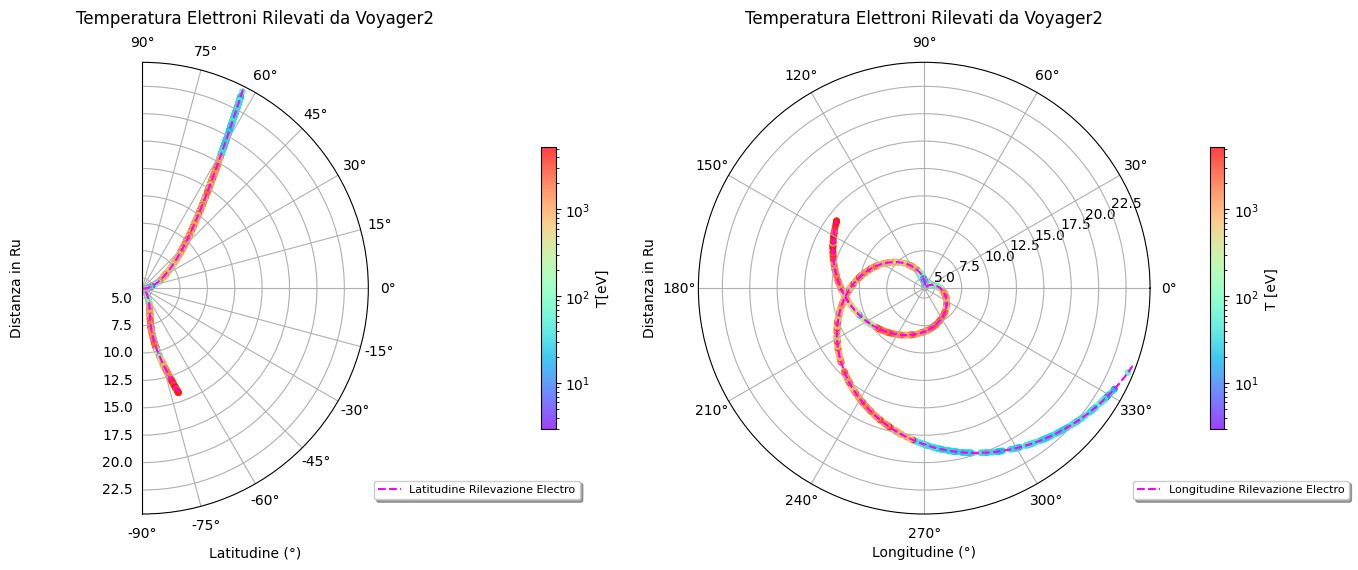

In [27]:
# Grafico 4: Rappresentazione delle Temperature Totali degli Elettroni:
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'polar': True}, figsize=(14,6))

# Grafico 1a: Meridian Chart
ax1.set_thetamin(0)
ax1.set_thetamax(180)
ax1.set_theta_zero_location('S')
ax1.set_theta_direction(1)

ax1.set_rlim(min(DF_U['distance vo2-uran'])-0.1,
             max(DF_U['distance vo2-uran'])+0.1)

latPLS_electro_plot = np.radians((DF_electro['lat_deg'])+90)
ax1.plot(latPLS_electro_plot, DF_electro['r'], color="magenta", linewidth=1.5, linestyle='--', label="Latitudine Rilevazione Electro")
sc1=ax1.scatter(latPLS_electro_plot,DF_electro['r'],c=DF_electro['temperature total'],cmap='rainbow', norm=LogNorm(),s=15,alpha=0.75)

# Aggiungo la Colorbar
cbar = plt.colorbar(sc1, ax=ax1, pad=0.1,shrink=0.5)
cbar.set_label("T[eV]")  # etichetta della variabile
# Adotto una formattazione logaritmica
cbar.formatter = ticker.LogFormatterMathtext(base=10)
cbar.update_ticks()

ax1.set_thetagrids([0,15,30,45,60,75,90,105,120,135,150,165,180],
                   labels=['-90°','-75°','-60°','-45°','-30°','-15°','0°','15°','30°','45°','60°','75°','90°'])
ax1.set_title('Temperatura Elettroni Rilevati da Voyager2', va='bottom')
ax1.set_xlabel('Latitudine (°)')
ax1.set_ylabel('Distanza in Ru')
ax1.legend(loc='lower left', bbox_to_anchor=(0.75, 0.02),
           frameon=True, shadow=True, fancybox=True, fontsize=8)

# Grafico 1b: Phase Chart
ax2.set_thetamin(0)
ax2.set_thetamax(360)
ax2.set_theta_zero_location('E')
ax2.set_theta_direction(1)

ax2.set_rlim(min(DF_U['distance vo2-uran'])-0.1,
             max(DF_U['distance vo2-uran'])+0.1)

lonPLS_electro_plot = np.radians((DF_electro['lon_deg']))
ax2.plot(lonPLS_electro_plot, DF_electro['r'], color="magenta", linewidth=1.5, linestyle='--', label="Longitudine Rilevazione Electro")
sc2=ax2.scatter(lonPLS_electro_plot, DF_electro['r'], c=DF_electro['temperature total'],cmap='rainbow',norm=LogNorm(),s=15,alpha=0.75)

# Qui si aggiunge la Colorbar
cbar = plt.colorbar(sc2, ax=ax2, pad=0.1,shrink=0.5)
cbar.set_label("T [eV]")  # etichetta della variabile
# Adotto una formattazione logaritmica
cbar.formatter = ticker.LogFormatterMathtext(base=10)
cbar.update_ticks()

ax2.set_thetagrids([0,30,60,90,120,150,180,210,240,270,300,330])
ax2.set_title('Temperatura Elettroni Rilevati da Voyager2', va='bottom')
ax2.set_xlabel('Longitudine (°)')
ax2.set_ylabel('Distanza in Ru', labelpad=30)
ax2.legend(loc='lower left', bbox_to_anchor=(0.95, 0.02),
           frameon=True, shadow=True, fancybox=True, fontsize=8)

# Mostro il risultato combinato
plt.tight_layout()
plt.show()

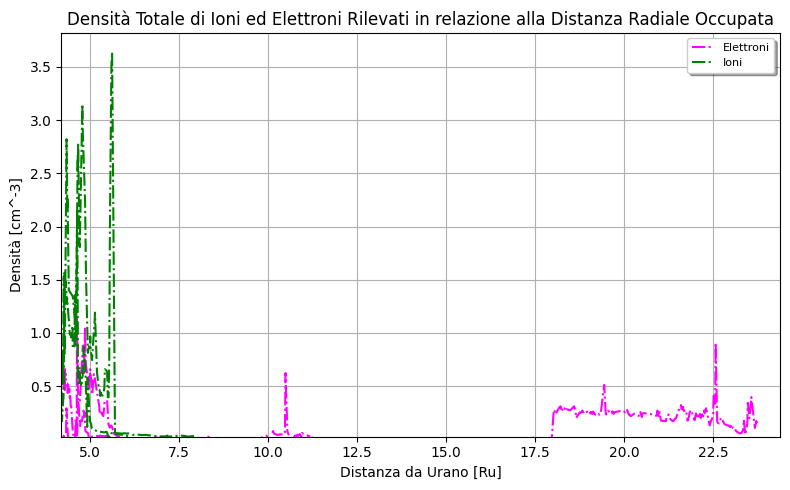

In [28]:
# Grafico 5: Rappresentazione della Densità Totale di Ioni ed Elettroni Rilevati in relazione alla Distanza Radiale Occupata 
fig3 = plt.figure(figsize=(8,5))
ax = plt.subplot(111) #Questo 111 serve a chiarire al programma che si vuole una sola area di disegno (1 riga, 1 colonna, 1° plot)

# Rappresentazione Grafica dei Dati
# Nel caso delle misurazioni inerenti gli elettroni è presente un valore "di disturbo" pari a "15.05", secondo mie supposizioni si tratta di un
# valore errato poiché non ha alcuna coerenza con i dati precedentemente e successivamente raccolti; decido quindi di escluderlo dalla 
# seguente figura per ottenere una migliore visualizzazione mediante utilizzo di una maschera:
# Creo la maschera: True per tutti i valori DIVERSI dal massimo
maschera = DF_electro['density total'] != DF_electro['density total'].max()

# La maschera avrà:
# - True per tutti i valori ≠ valore_max
# - False solo per il valore massimo

# Densità degli Elettroni:
ax.plot(DF_electro['r'][maschera], DF_electro['density total'][maschera], color='magenta', linewidth=1.5, linestyle='-.', label="Elettroni")
# Densità degli Ioni:
ax.plot(DF_ion['r'], density_total_ion, color='green', linewidth=1.5, linestyle='-.', label="Ioni")
# Densità Totale di Particelle Cariche:
#start=start = DF_electro.index.get_loc(pd.Timestamp("1986-01-24 15:02:31.172000")) #Valore più vicino all'inizio delle rilevazioni degli ioni
#total_density = DF_electro['density total'].copy()
#total_density.iloc[start:start+len(density_total_ion)] = (total_density.iloc[start:start+len(density_total_ion)].values
#+ density_total_ion.values)
#ax.plot(DF_electro['r'][maschera], total_density[maschera], color='yellow', linewidth=1, linestyle='--', label="Sum")

# Impostazioni sugli Assi e Raffigurazione: 
ax.set_xlim(min(DF_electro['r'][maschera]),max(DF_electro['r'][maschera]))
ax.set_ylim(min(density_total_ion))
ax.set(xlabel='Distanza da Urano [Ru]',ylabel='Densità [cm^-3]')
ax.set_title('Densità Totale di Ioni ed Elettroni Rilevati in relazione alla Distanza Radiale Occupata')
ax.grid()
# Inserisco la Legenda
ax.legend(loc='upper right', frameon=True, shadow=True, fancybox=True, fontsize=8)
# Mostra il grafico
plt.tight_layout()
plt.show()